In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import typing as npt

from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression, RANSACRegressor, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, mean_absolute_percentage_error, mean_squared_error, r2_score

**Esercizio 4.2.1**

Iniziamo caricando il dataset `tips`.

In [2]:
df = sns.load_dataset('tips')

Creiamo un oggetto di tipo `LinearRegression`, addestriamolo sul nostro dataset, e mostriamo a schermo i risultati.

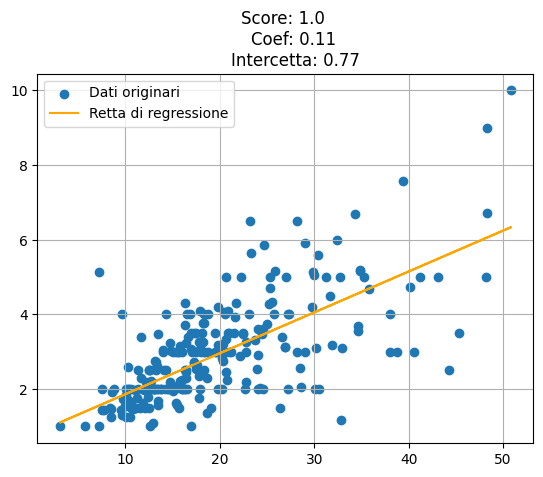

In [3]:
# Carico il dataset
df = sns.load_dataset('tips')
# Esercizio 16.1
lin_reg = LinearRegression()
X_reg = df['total_bill'].values.reshape(-1, 1)
y_reg = df['tip'].values.reshape(-1, 1)
X_reg_tr, X_reg_test, y_reg_tr, y_reg_test = train_test_split(X_reg, y_reg)
lin_reg.fit(X_reg_tr, y_reg_tr)
y_pred_show = lin_reg.predict(X_reg)
y_pred = lin_reg.predict(X_reg_test)
score = lin_reg.score(X_reg_test, y_pred)

plt.scatter(X_reg, y_reg, label='Dati originari')
plt.plot(X_reg, y_pred_show, color='orange', label='Retta di regressione')
plt.legend()
plt.grid()
plt.title(f'''Score: {round(score, 2)} 
    Coef: {round(lin_reg.coef_[0][0], 2)} 
    Intercetta: {round(lin_reg.intercept_[0], 2)}''')
plt.show()

**Esercizio 4.2.2**

Per evitare di riscrivere codice, creeremo la procedura `fit_plot_ransac`, che accetta i dati e le label presenti nel nostro dataset, oltre che la predizione del regressione lineare, il regressore stesso, ed il numero di iterazioni da considerare.

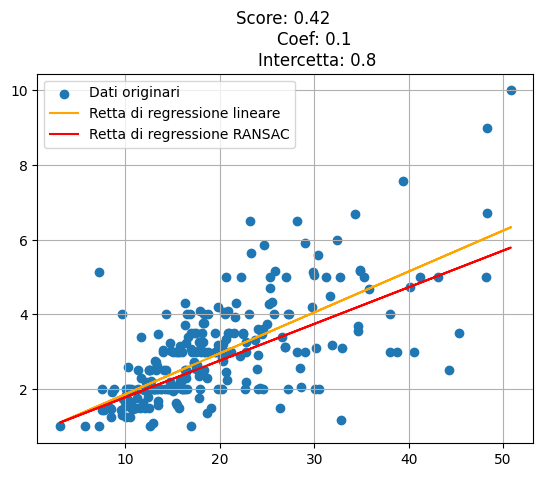

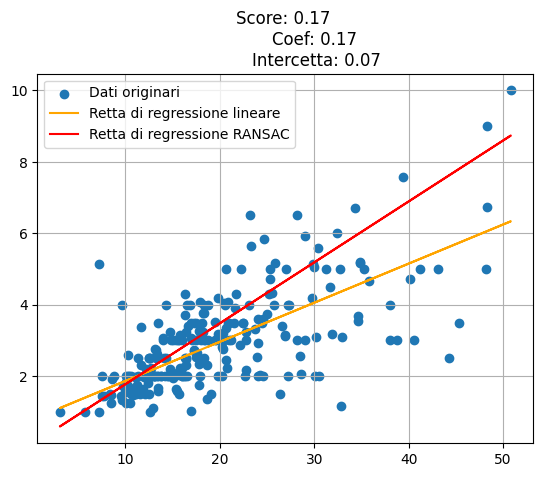

In [4]:
def fit_plot_ransac(
        X: npt.ArrayLike,
        y: npt.ArrayLike,
        y_pred: npt.ArrayLike,
        ran_reg: BaseEstimator,
        n_iters: int=2):
    """ Fitta e plotta un ransac.

    Argomenti:
        X: dati da utilizzare
        y: label dei campioni
        y_pred: predizioni di un regressore lineare
        ran_reg: istanza del regressore RANSAC
        n_iters: numero di iterazioni
    """
    for _ in range(n_iters):
        ran_reg = RANSACRegressor()
        ran_reg.fit(X, y)
        score = ran_reg.score(X, y)
        y_pred_ran = ran_reg.predict(X)
        plt.scatter(
            X,
            y,
            label='Dati originari')
        plt.plot(
            X,
            y_pred,
            color='orange',
            label='Retta di regressione lineare')
        plt.plot(
            X,
            y_pred_ran,
            color='red',
            label='Retta di regressione RANSAC')
        plt.legend()
        plt.grid()
        plt.title(f'''Score: {round(score, 2)} 
            Coef: {round(ran_reg.estimator_.coef_[0][0], 2)} 
            Intercetta: {round(ran_reg.estimator_.intercept_[0], 2)}''')
        plt.show()

ran_reg = RANSACRegressor()
fit_plot_ransac(X_reg, y_reg, y_pred_show, ran_reg)

**Esercizio 4.2.3**

Isoliamo i valori di `X` ed `y` che ci interessano, andando a considerarli esclusivamente sotto forma di array NumPy. Successivamente, usiamo la funzione `train_test_split` per selezionare il $70\%$ di dati di training ed il restante $30\%$ di dati di test.

In [5]:
X = df.loc[:, ('total_bill', 'tip', 'size')].values
y = df.loc[:, ('day')].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

Creiamo un regressore logistico, addestriamolo sui dati di training, e validiamolo sui dati di test. Verifichiamo i dati mediante la matrice di confusione.

Da notare che impostiamo il valore `max_iter` a `1000` per evitare che l'algoritmo non arrivi a convergenza.

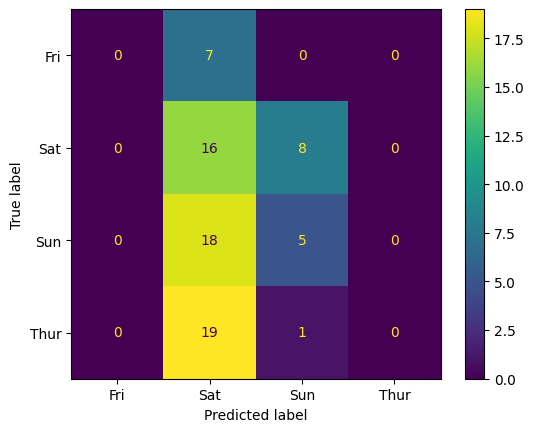

In [6]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

Notiamo come lo stimatore non restituisca (quasi) mai `Fri` come valore predetto. Per avere un'indizio sui motivi alla base di ciò, possiamo valutare il numero di volte in cui si pranza o si cena di venerdì.

In [7]:
tot_occ_fri = len(y[y == 'Fri'])
tot_occ = len(y)
print(f'Numero totale di pranzi/cene: {tot_occ}')
print(f'Numero totale di pranzi/cene di venerdì: {tot_occ_fri}')

Numero totale di pranzi/cene: 244
Numero totale di pranzi/cene di venerdì: 19


E' quindi evidente come, essendo il dataset molto sbilanciato, il nostro classificatore non è in grado di caratterizzare in maniera appropriata i pranzi o le cene che avvengono di venerdì.

**Esercizio 4.2.4**

Modifichiamo adesso la label, e riaddestriamo il nostro classificatore.

In [8]:
y = df.loc[:, ('time')].values
X_train, X_test, y_train, y_test = train_test_split(X, y)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

Valutiamo le probabilità associate a ciascuna predizione.

In [9]:
probs_pred = clf.predict_proba(X_test)
# Nota: considero soltanto i valori massimi per le predizioni
preds = [np.amax(pred) for pred in probs_pred]
y_pred = clf.predict(X_test)
preds_cls = list(zip(list(y_pred), preds, y_test))

Definiamo una funzione per contare i TP, TN, FP ed FN a partire dai valori di probabilità predetti dal regressore logistico secondo un valore arbitrario di soglia, e restituire la precisione ed il recall.

In [10]:
def get_precision_recall_from_probs(probs, threshold=0.5):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for prob in probs:
        if prob[1] > threshold and (prob[0] == prob[2]):
            # Abbiamo un true positive
            tp += 1
        elif prob[1] > threshold and (prob[0] != prob[2]):
            # Abbiamo un false positive
            fp += 1
        elif prob[1] <= threshold and (prob[0] == prob[2]):
            # Abbiamo un true negative
            tn += 1
        elif prob[1] <= threshold and (prob[0] != prob[2]):
            # Abbiamo un false negative
            fn += 1
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    return precision, recall

Usiamo la funzione `get_precision_recall_from_probs` per calcolare i valori di probabilità e recall al variare della soglia.

In [11]:
p_65, r_65 = get_precision_recall_from_probs(preds_cls, threshold=0.65)
p_80, r_80 = get_precision_recall_from_probs(preds_cls, threshold=0.80)
p_50, r_50 = get_precision_recall_from_probs(preds_cls, threshold=0.50)
print(f'Precisione e recall con soglia a 0.65\nPrecisione: {round(p_65, 2)} - Recall: {round(p_65, 2)}')
print(f'Precisione e recall con soglia a 0.8\nPrecisione: {round(p_80, 2)} - Recall: {round(p_80, 2)}')
print(f'Precisione e recall con soglia a 0.5\nPrecisione: {round(p_50, 2)} - Recall: {round(p_50, 2)}')

Precisione e recall con soglia a 0.65
Precisione: 0.7 - Recall: 0.7
Precisione e recall con soglia a 0.8
Precisione: 0.83 - Recall: 0.83
Precisione e recall con soglia a 0.5
Precisione: 0.67 - Recall: 0.67


**Esercizio 4.2.5**

In [12]:
print(f'MAPE: {mean_absolute_percentage_error(y_reg_test, y_pred), 2}')
print(f'MSE: {mean_squared_error(y_reg_test, y_pred), 2}')
print(f'R2: {round(r2_score(y_reg_test, y_pred), 2)}')

NameError: name 'mean_absolute_percentage_error' is not defined